Data preparation 

In [1]:
!wget -P data/ https://raw.githubusercontent.com/Gci04/AML-DS-2021/main/data/PosTagging/train_pos.txt

--2021-04-19 07:21:19--  https://raw.githubusercontent.com/Gci04/AML-DS-2021/main/data/PosTagging/train_pos.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1855828 (1.8M) [text/plain]
Saving to: ‘data/train_pos.txt’

train_pos.txt       100%[===================>]   1.77M  --.-KB/s    in 0.09s   

2021-04-19 07:21:19 (20.2 MB/s) - ‘data/train_pos.txt’ saved [1855828/1855828]



In [2]:
!wget -P data/ https://raw.githubusercontent.com/Gci04/AML-DS-2021/main/data/PosTagging/test_pos.txt

--2021-04-19 07:21:19--  https://raw.githubusercontent.com/Gci04/AML-DS-2021/main/data/PosTagging/test_pos.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 418682 (409K) [text/plain]
Saving to: ‘data/test_pos.txt’

test_pos.txt        100%[===================>] 408.87K  --.-KB/s    in 0.03s   

2021-04-19 07:21:19 (11.6 MB/s) - ‘data/test_pos.txt’ saved [418682/418682]



In [3]:
import numpy as np

In [4]:
with open("data/train_pos.txt", "r") as file:
  sents = file.read().split(" \n")
with open("data/test_pos.txt", "r") as file:
  sents_test = file.read().split(" \n")

In [5]:
train_data_raw = np.array([[(word_tag.split()) for word_tag in sent.split("\n") if len(word_tag.split()) == 2] for sent in sents])[:-1]
test_data_raw = np.array([[(word_tag.split()) for word_tag in sent.split("\n") if len(word_tag.split()) == 2] for sent in sents_test])[:-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [275]:
from functools import reduce
words_voc = [' '] + list(set([word for word, _ in list(reduce(lambda x,y: np.concatenate((x, y), axis=0), np.concatenate((train_data_raw, test_data_raw))))]))
tags_voc = [' '] + list(set([tag for _, tag in list(reduce(lambda x,y: np.concatenate((x, y), axis=0), np.concatenate((train_data_raw, test_data_raw))))]))

In [276]:
word_to_ind = {}
for index, word in enumerate(words_voc):
  word_to_ind[word] = index
tag_to_ind = {}
for index, tag in enumerate(tags_voc):
  tag_to_ind[tag] = index

In [284]:
MAX_LEN = 40
def post(sample, max_len = MAX_LEN):
  res = np.zeros(max_len, dtype=np.int16)
  for ind, w in enumerate(sample):
    if ind >= max_len:
      break
    res[ind] = w
  return res

In [285]:
x_train = []
y_train = []
for sent in train_data_raw:
  x_train.append(post([word_to_ind[word] for word, _ in sent]))
  y_train.append(post([tag_to_ind[tag] for _, tag in sent]))
x_test = []
y_test = []
for sent in test_data_raw:
  x_test.append(post([word_to_ind[word] for word, _ in sent]))
  y_test.append(post([tag_to_ind[tag] for _, tag in sent]))
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)


In [263]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers #import Input, LSTM, Dense, Embedding
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  LearningRateScheduler
from tensorflow.math import exp
vocab_size = len(words_voc) + 1


Calculation the transition probability and emission matrices

In [286]:
T = np.zeros((len(tags_voc),len(tags_voc)))
W = np.zeros((len(tags_voc),len(words_voc)))
P_P = np.zeros((len(tags_voc)))

In [287]:
for sent, tags in list(zip(x_train, y_train)):
  for word, tag in list(zip(sent, tags)):
    W[tag][word] += 1
    P_P[tag] += 1
  for i in range(1,len(tags) - 1):
    T[tags[i - 1]][tags[i]] += 1

for i in range(T.shape[0]):
  T[i] /= np.sum(T[i])
for i in range(W.shape[0]):
  W[i] /= np.sum(W[i]) 
P_P /= np.sum(P_P)

Viterbi algorithm

In [299]:
def viterbi(x):
  cur_probs = np.zeros((T.shape[0]))
  seq = []
  for word in x:
    if word == x[0]:
      cur_probs = np.exp(np.log(P_P) + np.log(W[:,word]))
      # for i in range(cur_probs.shape[0]):
      #   cur_probs[i] = P_P[i] * W[i][word]
      
    else:
      last_prob = np.array(cur_probs)
      cur_probs = np.zeros((T.shape[0]))
      cur_probs = np.sum(np.exp((np.log(last_prob) + np.log(T).T).T + np.log(W[:,word]).T), axis = 0)
      # for i in range(cur_probs.shape[0]):
      #   cur_probs[i] = np.sum(np.exp(np.log(last_prob) + np.log(T[:,i]) + np.log(W[i,word])))
        # for j in range(cur_probs.shape[0]):
        #   cur_probs[i] += last_prob[j] * T[j][i] * W[i][word]
    seq.append(np.argmax(cur_probs))
  return seq

In [300]:
def evaluate_viterbi(x_, y_):
  acc = 0
  c = 0
  for i in range(x_.shape[0]):
    y_pred = viterbi(x_[i])
    y_true = y_[i]
    for pred, obs in list(zip(y_pred, y_true)):
      if pred == obs:
        acc += 1
      c += 1
      # print(pred, obs,"\n") 
  # acc /= c 
  return acc/c
print("Training accuracy - ", evaluate_viterbi(x_train,y_train))
print("Testing accuracy - ", evaluate_viterbi(x_test,y_test))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


Training accuracy -  0.9888009176365264
Testing accuracy -  0.676814115308151


In [268]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit([[i] for i in range(len(tags_voc))])


OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=True)

In [269]:
y_train = np.array([(enc.transform(samp.reshape(-1, 1))).toarray() for samp in y_train])
y_test = np.array([(enc.transform(samp.reshape(-1, 1))).toarray() for samp in y_test])

Recurrent Neural Network for POS tagging task

In [270]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=100, 
                           input_length=MAX_LEN))
# model.add(layers.LSTM(250, activation='relu', return_sequences=True)) #,kernel_regularizer=regularizers.l1_l2(l1=1e-8, l2=1e-8)
# model.add(layers.Conv2D(25, (1,5)), activation='relu')
model.add(layers.LSTM(180, activation='relu', return_sequences=True)) #, kernel_regularizer=regularizers.l1_l2(l1=1e-8, l2=1e-8)
model.add(layers.Dropout(0.1))
model.add(layers.Dense(100, activation='relu')) #, kernel_regularizer=regularizers.l1_l2(l1=1e-8, l2=1e-8)
model.add(layers.Dropout(0.1))
model.add(layers.Dense(len(tags_voc), activation='softmax'))
model.compile(optimizer=Adam(learning_rate = 0.0099),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 40, 100)           2159000   
_________________________________________________________________
lstm_17 (LSTM)               (None, 40, 180)           202320    
_________________________________________________________________
dropout_12 (Dropout)         (None, 40, 180)           0         
_________________________________________________________________
dense_22 (Dense)             (None, 40, 100)           18100     
_________________________________________________________________
dropout_13 (Dropout)         (None, 40, 100)           0         
_________________________________________________________________
dense_23 (Dense)             (None, 40, 44)            4444      
Total params: 2,383,864
Trainable params: 2,383,864
Non-trainable params: 0
___________________________________________

In [271]:
def scheduler(epoch, lr):
   if epoch < 8:
     return lr
   else:
     return lr * 0.9

In [272]:
callback = LearningRateScheduler(scheduler)
history = model.fit(x_train, y_train,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    batch_size=128,
                    callbacks = [callback])

Epoch 1/20
70/70 [==============================] - 27s 357ms/step - loss: 3158.0327 - accuracy: 0.2640 - val_loss: 1.5558 - val_accuracy: 0.5578
Epoch 2/20
70/70 [==============================] - 23s 322ms/step - loss: 1.4510 - accuracy: 0.5930 - val_loss: 1.0754 - val_accuracy: 0.7102
Epoch 3/20
70/70 [==============================] - 22s 316ms/step - loss: 0.9696 - accuracy: 0.7373 - val_loss: 0.6742 - val_accuracy: 0.8149
Epoch 4/20
70/70 [==============================] - 21s 305ms/step - loss: 0.6194 - accuracy: 0.8304 - val_loss: 0.5018 - val_accuracy: 0.8635
Epoch 5/20
70/70 [==============================] - 23s 332ms/step - loss: 0.4527 - accuracy: 0.8744 - val_loss: 0.4115 - val_accuracy: 0.8870
Epoch 6/20
70/70 [==============================] - 22s 315ms/step - loss: 0.3568 - accuracy: 0.9002 - val_loss: 0.3605 - val_accuracy: 0.9018
Epoch 7/20
70/70 [==============================] - 22s 319ms/step - loss: 0.2855 - accuracy: 0.9199 - val_loss: 0.3175 - val_accuracy: 0.9

In [301]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

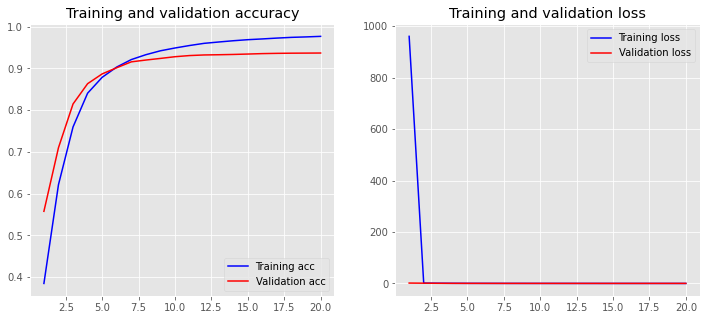

In [302]:
plot_history(history)

In [273]:
model.save("model.h5")

In [274]:
def get_tags(sentence, method = 'HMM'):
  """
  method can be RNN or HMM
  """
  size = len(sentence.split())
  x = post([word_to_ind[word] if word in word_to_ind else 0  for word in sentence.split()])
  x = np.array(x, dtype=np.int16)
  # print(x)
  if method == "RNN":
    res = model.predict(x).reshape(MAX_LEN,len(tags_voc))
    res = [enc.inverse_transform([tag]).reshape(-1)[0] for tag in res]
  if method == "HMM":
    res = viterbi(x)
  # print(res)
  return ' '.join([tags_voc[tid] for tid in res[:size]])

In [157]:
test = ' '.join([words_voc[int(wid)] for wid in x_train[0]])
print(test)

Confidence in the pound is widely expected to take another sharp dive if trade figures for September , due for release tomorrow , fail to show a substantial improvement from July and August 's near-record deficits .      


In [160]:
get_tags(test, "HMM")

'NN IN DT NN VBZ RB VBN TO VB DT JJ NN IN NN NNS IN NNP , JJ IN NN NN , VB TO VB DT JJ NN IN NNP CC NNP POS JJ NNS .      '

In [164]:
get_tags(test, "RNN")

'NN IN DT NN IN RB VBN CC NNP NNP JJ NN IN NN NNS IN NNP , JJ IN NN NN , VB CC NN DT JJ NN IN NNP CC NNP CC JJ NNS NNP'